In [5]:
#https://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html#sphx-glr-auto-examples-transform-plot-matching-py
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

import os
from urllib.request import urlopen
#from utils_imgprocessing import *

directory_work = "/content/drive/My Drive/Work/01_ProyectoARIA" #ScrappingWeb.ipynb
os.chdir(directory_work)

def load_code_from_url(url_path):
  code_str = urlopen(url_path).read()
  code_str = code_str.decode('utf-8')
  exec(code_str)
  return code_str

Mounted at /content/drive/


In [2]:
code_str = load_code_from_url("https://raw.githubusercontent.com/hoat23/VisionArtificialAndImageProcessing/master/bin/utils_imgprocessing.py")
exec(code_str)

In [8]:
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage import segmentation
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

In [9]:
# generate synthetic checkerboard image and add gradient for the later matching
def build_checkerboard():
  checkerboard = img_as_float(data.checkerboard())
  img_tmp = np.zeros(list(checkerboard.shape) + [3])
  img_tmp[..., 0] = checkerboard
  gradient_r, gradient_c = (np.mgrid[0:img_tmp.shape[0],
                                    0:img_tmp.shape[1]]
                            / float(img_tmp.shape[0]))
  img_tmp[..., 1] = gradient_r
  img_tmp[..., 2] = gradient_c
  img_tmp = rescale_intensity(img_tmp)
  return img_tmp

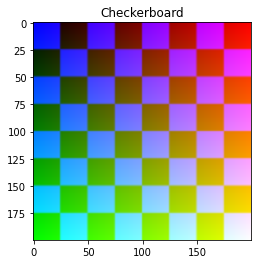

In [25]:
# data.astronaut() or build_checkerboard()
img_orig = build_checkerboard()
img_orig_gray = rgb2gray(img_orig)
plot_img(img_orig, title='Checkerboard')

Warp Synthetic Image 
scale      : (0.9, 0.9)
rotation   : 0.2
translation: (20, -10)
shape      : (200, 200, 3)


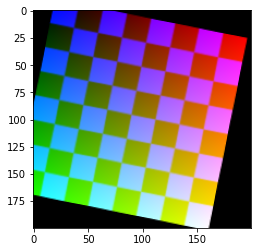

In [26]:
# warp synthetic image
scale = (0.9, 0.9)
rotation = 0.2
translation = (20, -10)
output_shape = img_orig.shape
print("Warp Synthetic Image ")
print("scale      :", scale)
print("rotation   :", rotation)
print("translation:", translation)
print("shape      :", img_orig.shape)

tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=output_shape)
img_warped_gray = rgb2gray(img_warped)

plot_img(img_warped)

In [27]:
# extract corners using Harris' corner measure
threshold_rel = 0.001
min_distance = 5
window_size = 9

coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=threshold_rel,
                           min_distance=min_distance)
coords_warped = corner_peaks(corner_harris(img_warped_gray), threshold_rel=threshold_rel,
                           min_distance=min_distance)
print("- Corners using Harris corner measure")
print("   corners original :", coords_orig.size)
print("     P0_xy:", coords_orig[0])
print("   coords_warped    :", coords_warped.size)
print("     P0_xy:", coords_warped[0])

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=window_size)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=window_size)
print("- Sub-pixel corner position")
print("   window size:", window_size)
print("     coords orig subpix:", coords_orig_subpix.size)
print("     P0_xy", coords_orig_subpix[0])
print("   coords warped subpix:", coords_warped_subpix.size)
print("     P0_xy", coords_warped_subpix[0])


- Corners using Harris corner measure
   corners original : 98
     P0_xy: [24 49]
   coords_warped    : 136
     P0_xy: [  8 108]
- Sub-pixel corner position
   window size: 9
     coords orig subpix: 98
     P0_xy [24.48251411 49.36188145]
   coords warped subpix: 136
     P0_xy [  7.4228203  108.03951144]


In [28]:
def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]

In [29]:
# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False

In [30]:
# compare "true" and estimated transform parameters
print("Ground truth:")
print(f"Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), "
      f"Translation: ({tform.translation[1]:.4f}, "
      f"{tform.translation[0]:.4f}), "
      f"Rotation: {-tform.rotation:.4f}")
print("Affine transform:")
print(f"Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), "
      f"Translation: ({model.translation[0]:.4f}, "
      f"{model.translation[1]:.4f}), "
      f"Rotation: {model.rotation:.4f}")
print("RANSAC:")
print(f"Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), "
      f"Translation: ({model_robust.translation[0]:.4f}, "
      f"{model_robust.translation[1]:.4f}), "
      f"Rotation: {model_robust.rotation:.4f}")

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


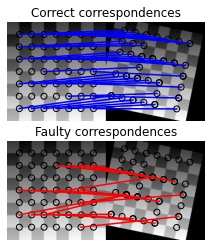

In [31]:
# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)
plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()